# Import Libraries

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
import seaborn as sns

TRAIN = "./data/training.csv"
TEST = "./data/test.csv"
TARGET = "DiagPeriodL90D"

In [52]:
training = pd.read_csv(TRAIN)
test = pd.read_csv(TEST)

In [53]:
training.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12906 entries, 0 to 12905
Data columns (total 83 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   patient_id                             12906 non-null  int64  
 1   patient_race                           6521 non-null   object 
 2   payer_type                             11103 non-null  object 
 3   patient_state                          12855 non-null  object 
 4   patient_zip3                           12906 non-null  int64  
 5   patient_age                            12906 non-null  int64  
 6   patient_gender                         12906 non-null  object 
 7   bmi                                    3941 non-null   float64
 8   breast_cancer_diagnosis_code           12906 non-null  object 
 9   breast_cancer_diagnosis_desc           12906 non-null  object 
 10  metastatic_cancer_diagnosis_code       12906 non-null  object 
 11  me

In [54]:
pd.pivot_table(training, index="DiagPeriodL90D", values=["patient_age", "bmi", "density", "age_median", "disabled", "poverty", "Ozone", "N02"], aggfunc="median")

,N02,Ozone,age_median,bmi,density,disabled,patient_age,poverty
DiagPeriodL90D,,,,,,,,
0,15.375009,39.070037,40.583333,28.275,688.005263,12.951220,58,12.535714
1,15.589148,39.139001,40.639344,28.150,701.423913,12.832787,59,12.118919


In [55]:
pd.pivot_table(training, index="DiagPeriodL90D", values=["patient_age", "bmi", "density", "age_median", "disabled", "poverty", "Ozone", "N02"], aggfunc=np.std)

,N02,Ozone,age_median,bmi,density,disabled,patient_age,poverty
DiagPeriodL90D,,,,,,,,
0,5.882738,3.542065,4.042851,5.521966,3151.927168,3.692690,12.917466,5.224511
1,5.818540,3.569973,4.033669,5.817665,2848.373287,3.688904,13.548505,5.219032


# Checking for Usable Fields with low Nulls

In [56]:
training.isnull().mean().mul(100).sort_values(ascending=False).round(6).head(50)

metastatic_first_novel_treatment         99.814040
metastatic_first_novel_treatment_type    99.814040
bmi                                      69.463815
patient_race                             49.473113
payer_type                               13.970246
Region                                    0.402913
Division                                  0.402913
patient_state                             0.395165
N02                                       0.224702
PM25                                      0.224702
Ozone                                     0.224702
income_household_25_to_35                 0.030993
income_household_15_to_20                 0.030993
income_household_35_to_50                 0.030993
income_household_20_to_25                 0.030993
limited_english                           0.030993
income_household_10_to_15                 0.030993
income_household_75_to_100                0.030993
income_household_under_5                  0.030993
income_household_median        

<AxesSubplot:ylabel='patient_race'>

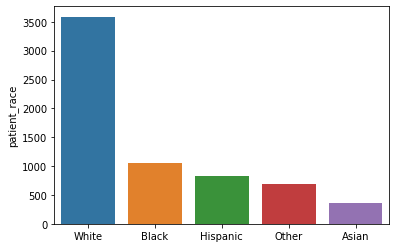

In [57]:
sns.barplot(training["patient_race"].value_counts().index, training["patient_race"].value_counts())

In [58]:
training.groupby(by="patient_race")[["patient_age",'race_white','race_black','race_asian','race_other','race_multiple','hispanic', TARGET]].mean()

,patient_age,race_white,race_black,race_asian,race_other,race_multiple,hispanic,DiagPeriodL90D
patient_race,,,,,,,,
Asian,58.386301,54.642855,10.749983,13.620138,11.005060,8.767737,28.586318,0.630137
Black,58.443182,56.160710,26.382709,5.073532,5.760398,5.996320,16.489908,0.613636
Hispanic,55.316043,59.814617,8.579597,8.411795,11.837369,10.250205,38.964538,0.632087
Other,57.171303,67.972583,10.716798,6.342526,6.362847,7.444294,21.272733,0.626647
White,61.671962,74.809587,9.126463,4.466753,4.506008,6.116373,15.308805,0.659142


In [59]:
# Replace Null values in Race
CONDITIONS = [
    training["race_asian"] > 13.5,   
    training["race_black"] > 26,
    training["hispanic"] > 38.5,
    training["race_white"] > 74.5,
    True 
]

CONDITIONS2 = [
    test["race_asian"] > 13.5,   
    test["race_black"] > 26,
    test["hispanic"] > 38.5,
    test["race_white"] > 74.5,
    True 
]
    

RACE = ["Asian", "Black", "Hispanic", "White", "Other"]

training["race"] = np.where(training["patient_race"].notnull(), training["patient_race"], np.select(CONDITIONS, RACE)) 
test["race"] = np.where(test["patient_race"].notnull(), test["patient_race"], np.select(CONDITIONS2, RACE)) 

training["race"] = training["race"].replace(RACE, [i for i in range(len(RACE))])
test["race"] = test["race"].replace(RACE, [i for i in range(len(RACE))])

In [60]:
training.groupby(by="race")[["patient_age",'race_white','race_black','race_asian','race_other','race_multiple','hispanic', TARGET]].mean()

,patient_age,race_white,race_black,race_asian,race_other,race_multiple,hispanic,DiagPeriodL90D
race,,,,,,,,
0,58.535604,51.497250,8.687285,18.668800,10.917506,9.039982,27.664751,0.642931
1,58.327179,52.777626,30.012165,4.975383,5.939482,5.687442,15.335924,0.601538
2,56.342105,59.955650,8.475876,6.991702,12.214794,11.214733,43.863091,0.625346
3,60.544793,80.256637,6.915906,3.316525,3.301102,5.302145,11.800887,0.632863
4,57.856629,67.276803,11.795880,5.566388,6.041664,7.551659,20.723548,0.609455


In [61]:
PAYER = ['MEDICAID', 'COMMERCIAL', 'MEDICARE ADVANTAGE']
training["payer_type"] = training["payer_type"].fillna(3)
training["payer_type"] = training["payer_type"].replace(PAYER, [i for i in range(len(PAYER))])

test["payer_type"] = test["payer_type"].fillna(3)
test["payer_type"] = test["payer_type"].replace(PAYER, [i for i in range(len(PAYER))])

In [62]:
training[["breast_cancer_diagnosis_code","breast_cancer_diagnosis_desc","metastatic_cancer_diagnosis_code"]]

,breast_cancer_diagnosis_code,breast_cancer_diagnosis_desc,metastatic_cancer_diagnosis_code
0,C50919,Malignant neoplasm of unsp site of unspecified...,C7989
1,C50411,Malig neoplm of upper-outer quadrant of right ...,C773
2,C50112,Malignant neoplasm of central portion of left ...,C773
3,C50212,Malig neoplasm of upper-inner quadrant of left...,C773
4,1749,"Malignant neoplasm of breast (female), unspeci...",C773
...,...,...,...
12901,C50411,Malig neoplm of upper-outer quadrant of right ...,C773
12902,C50912,Malignant neoplasm of unspecified site of left...,C773
12903,C50912,Malignant neoplasm of unspecified site of left...,C7931
12904,1749,"Malignant neoplasm of breast (female), unspeci...",C773


### Breast cancer code simplification

In [63]:
training["breast_cancer_diagnosis_code"] = training["breast_cancer_diagnosis_code"].apply(lambda x: x[:4])
training["metastatic_cancer_diagnosis_code"] = training["metastatic_cancer_diagnosis_code"].apply(lambda x: x[:4])

test["breast_cancer_diagnosis_code"] = test["breast_cancer_diagnosis_code"].apply(lambda x: x[:4])
test["metastatic_cancer_diagnosis_code"] = test["metastatic_cancer_diagnosis_code"].apply(lambda x: x[:4])

> Replaced with just first 3 numerical values

In [64]:
waste = ["metastatic_first_novel_treatment", "metastatic_first_novel_treatment_type", "bmi", "patient_race", "patient_gender", "breast_cancer_diagnosis_desc", "patient_state"]

training = training.drop(waste, axis=1)
test = test.drop(waste, axis=1)

In [65]:
categorical = training.select_dtypes(include=['object']).columns
numerical = training.select_dtypes(exclude=['object']).columns

In [66]:
for col in categorical:
    if col != 'DiagPeriodL90D':
        mode = training[col].mode()[0]
        training[col].fillna(mode, inplace=True)
        test[col].fillna(mode, inplace=True)

for col in numerical:
    if col != 'DiagPeriodL90D':
        mean = training[col].median()
        training[col].fillna(mean, inplace=True)
        test[col].fillna(mean, inplace=True)

In [67]:
training.isnull().mean().mul(100).sort_values(ascending=False).round(6).head(70)

patient_id                   0.0
education_some_college       0.0
self_employed                0.0
unemployment_rate            0.0
labor_force_participation    0.0
                            ... 
income_household_15_to_20    0.0
income_household_10_to_15    0.0
income_household_5_to_10     0.0
income_household_under_5     0.0
income_household_median      0.0
Length: 70, dtype: float64

In [68]:
for col in categorical:
    print(training[col].unique())

['C509' 'C504' 'C501' 'C502' '1749' 'C505' '1744' 'C508' 'C503' '1741'
 '1748' '1743' 'C500' '1742' 'C506' '1746' '1988' '1745' 'C50' '1759']
['C798' 'C773' 'C779' 'C780' 'C799' 'C781' 'C786' 'C795' 'C792' 'C787'
 'C771' 'C793' 'C770' 'C782' 'C794' 'C788' 'C785' 'C778' 'C784' 'C796'
 'C772' 'C797' 'C774' 'C791' 'C790' 'C775' 'C783']
['West' 'South' 'Northeast' 'Midwest']
['Pacific' 'West South Central' 'Mountain' 'Middle Atlantic'
 'East North Central' 'East South Central' 'South Atlantic'
 'West North Central' 'New England']


In [69]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

for col in categorical.to_list():
    print(col)
    encoder.fit(training[[col]])
    training[col] = encoder.transform(training[[col]])
    test[col] = encoder.transform(test[col])   

breast_cancer_diagnosis_code
metastatic_cancer_diagnosis_code
Region
Division


In [70]:
training.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12906 entries, 0 to 12905
Data columns (total 77 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   patient_id                        12906 non-null  int64  
 1   payer_type                        12906 non-null  int64  
 2   patient_zip3                      12906 non-null  int64  
 3   patient_age                       12906 non-null  int64  
 4   breast_cancer_diagnosis_code      12906 non-null  int64  
 5   metastatic_cancer_diagnosis_code  12906 non-null  int64  
 6   Region                            12906 non-null  int64  
 7   Division                          12906 non-null  int64  
 8   population                        12906 non-null  float64
 9   density                           12906 non-null  float64
 10  age_median                        12906 non-null  float64
 11  age_under_10                      12906 non-null  float64
 12  age_

### Normalization

In [71]:
norm_training = training
norm_test = test
for col in training:
    if (col != TARGET and col != "patient_id"):
        norm_training[col] = (training[col] - training[col].mean()) / training[col].std()
        norm_test[col] = (test[col] - test[col].mean()) / test[col].std()


In [72]:
import optuna
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import warnings

warnings.filterwarnings('ignore')

x_train, x_val, y_train, y_val = train_test_split(norm_training.drop(columns=[TARGET], axis=1), norm_training[TARGET], test_size=0.2)

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=100),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
        'subsample': trial.suggest_discrete_uniform('subsample', 0.5, 0.9, 0.1),
        'colsample_bytree': trial.suggest_discrete_uniform('colsample_bytree', 0.5, 0.9, 0.1),
    }

    model = XGBClassifier(**params)


    model.fit(x_train, y_train)

    y_pred = model.predict(x_val)
    accuracy = accuracy_score(y_val, y_pred)

    return accuracy


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2024-02-23 19:37:47,678] A new study created in memory with name: no-name-dbdcbe0c-6ad4-4550-9b7d-37c9bd371ee7


[I 2024-02-23 19:37:49,819] Trial 0 finished with value: 0.8009295120061968 and parameters: {'n_estimators': 200, 'max_depth': 6, 'learning_rate': 0.06886278462701474, 'subsample': 0.8, 'colsample_bytree': 0.6}. Best is trial 0 with value: 0.8009295120061968.
[I 2024-02-23 19:37:54,092] Trial 1 finished with value: 0.8044151820294345 and parameters: {'n_estimators': 800, 'max_depth': 3, 'learning_rate': 0.03804168855910591, 'subsample': 0.5, 'colsample_bytree': 0.8}. Best is trial 1 with value: 0.8044151820294345.
[I 2024-02-23 19:38:00,427] Trial 2 finished with value: 0.7656855151045701 and parameters: {'n_estimators': 400, 'max_depth': 8, 'learning_rate': 0.09347764966325323, 'subsample': 0.5, 'colsample_bytree': 0.8}. Best is trial 1 with value: 0.8044151820294345.
[I 2024-02-23 19:38:15,357] Trial 3 finished with value: 0.7970565453137103 and parameters: {'n_estimators': 900, 'max_depth': 9, 'learning_rate': 0.011563730549836731, 'subsample': 0.9, 'colsample_bytree': 0.8}. Best is

KeyboardInterrupt: 

In [ ]:
print("===========BEST TRIAL=============")
print(study.best_trial)
print()
print(study.best_params)

===========BEST TRIAL=============
FrozenTrial(number=10, state=TrialState.COMPLETE, values=[0.8024786986831913], datetime_start=datetime.datetime(2024, 2, 23, 18, 26, 9, 310081), datetime_complete=datetime.datetime(2024, 2, 23, 18, 26, 10, 693913), params={'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.04009858923456953, 'subsample': 0.9, 'colsample_bytree': 0.5}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=1000, log=False, low=100, step=100), 'max_depth': IntDistribution(high=10, log=False, low=3, step=1), 'learning_rate': FloatDistribution(high=0.1, log=True, low=0.01, step=None), 'subsample': FloatDistribution(high=0.9, log=False, low=0.5, step=0.1), 'colsample_bytree': FloatDistribution(high=0.9, log=False, low=0.5, step=0.1)}, trial_id=10, value=None)

{'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.04009858923456953, 'subsample': 0.9, 'colsample_bytree': 0.5}


In [75]:
params = {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.04009858923456953, 'subsample': 0.9, 'colsample_bytree': 0.5}

model = XGBClassifier(**params)
model.fit(x_train, y_train)

out = pd.DataFrame()
out["patient_id"] = test.patient_id
out[TARGET] = model.predict(test)

out.to_csv("sumbission.csv", index=False)
